In [ ]:
!pip install --quiet --upgrade tensorflow-federated==0.20.0
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

     |████████████████████████████████| 819 kB 5.0 MB/s 
     |████████████████████████████████| 65.1 MB 80 kB/s 
     |████████████████████████████████| 251 kB 36.1 MB/s 
     |████████████████████████████████| 53 kB 423 kB/s 
     |████████████████████████████████| 4.0 MB 27.6 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
     |████████████████████████████████| 887 kB 61.1 MB/s 
     |████████████████████████████████| 237 kB 55.9 MB/s 
     |████████████████████████████████| 121 kB 56.0 MB/s 
     |████████████████████████████████| 462 kB 49.8 MB/s 
     |████████████████████████████████| 4.2 MB 46.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
pymc3 3.11.4 requires cachetools>=4.2.1, but you have cachetools 3.1.1 which is incompatible.
panel 0.1

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [ ]:
cifar_train, cifar_test = tff.simulation.datasets.cifar100.load_data()

In [ ]:
len(cifar_train.client_ids)

500

In [ ]:
cifar_train.element_type_structure

OrderedDict([('coarse_label', TensorSpec(shape=(), dtype=tf.int64, name=None)),
             ('image',
              TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)),
             ('label', TensorSpec(shape=(), dtype=tf.int64, name=None))])

In [ ]:
example_dataset = cifar_train.create_tf_dataset_for_client(
    cifar_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

0

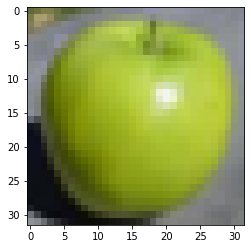

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(example_element['image'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

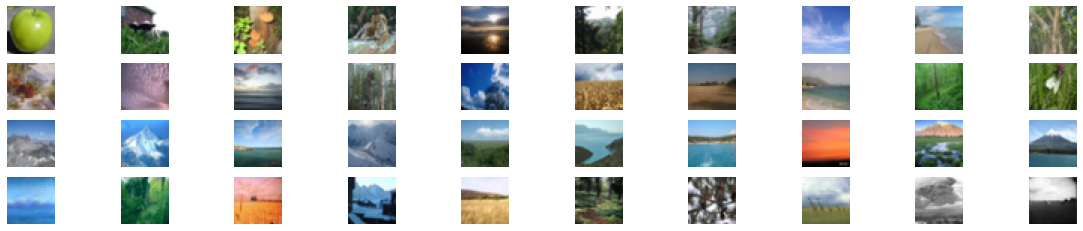

In [ ]:
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['image'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

In [ ]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['image'], [-1, 3072]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [ ]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[ 52, 101, 167, ..., 110, 114, 117],
                     [ 99, 103,  61, ..., 121, 125, 124],
                     [ 21,  31,  38, ...,  11,  11,  17],
                     ...,
                     [138, 153, 167, ...,  59,  49,  40],
                     [ 33,  50,  26, ..., 114, 132,  87],
                     [254, 254, 254, ..., 251, 251, 251]], dtype=uint8)),
             ('y', array([[49],
                     [ 0],
                     [49],
                     [33],
                     [27],
                     [49],
                     [49],
                     [63],
                     [93],
                     [60],
                     [29],
                     [49],
                     [71],
                     [23],
                     [93],
                     [88],
                     [51],
                     [33],
                     [51],
                     [29]]))])

In [ ]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [ ]:
NUM_CLIENTS = 100
sample_clients = cifar_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(cifar_train, sample_clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 100
First dataset: <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 3072), dtype=tf.uint8, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>


In [ ]:
#2nd Model
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3072,)),
      tf.keras.layers.Dense(1000),
      tf.keras.layers.Dense(100, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

In [ ]:
# 1st Model
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3072,)),
      tf.keras.layers.Dense(100, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

In [ ]:
preprocessed_example_dataset.element_spec

OrderedDict([('x', TensorSpec(shape=(None, 3072), dtype=tf.uint8, name=None)),
             ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])

In [ ]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [ ]:
print(iterative_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[3072,100],
      float32[100]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [ ]:
state = iterative_process.initialize()

In [ ]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.12126), ('loss', 13.710508), ('num_examples', 50000), ('num_batches', 2500)]))])


In [ ]:
NUM_ROUNDS = 3
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.02192), ('loss', 15.761333), ('num_examples', 12500), ('num_batches', 625)]))])


In [ ]:
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
print(evaluation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[3072,100],
      float32[100]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=uint8[?,3072],
    y=int64[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    sparse_categorical_accuracy=float32,
    loss=float32,
    num_examples=int64,
    num_batches=int64
  >
>@SERVER)


In [ ]:
train_metrics = evaluation(state.model, federated_train_data)

In [ ]:
str(train_metrics)

"OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.0166), ('loss', 15.850555), ('num_examples', 50000), ('num_batches', 2500)]))])"

In [ ]:
sample_test_clients = cifar_test.client_ids[0:NUM_CLIENTS]

In [ ]:
federated_test_data = make_federated_data(cifar_test, sample_test_clients)

In [ ]:
test_metrics = evaluation(state.model, federated_test_data)

In [ ]:
str(test_metrics)

"OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.01), ('loss', 15.956938), ('num_examples', 50000), ('num_batches', 2500)]))])"